**How Keras Tuner and ConvLSTM Can Work Together for Your TEC Project**
Link of Keras Tuner and ConvLSTM as two completely different tools that work amazingly well together - kind of like how a good chef (Keras Tuner) can make the best use of a specialized cooking technique (ConvLSTM)!

***What Each One Does***

**ConvLSTM** is a special type of neural network layer that's really good at understanding patterns that have both space and time components. Imagine watching clouds move across the sky - ConvLSTM can understand both the shape of the clouds (spatial) and how they're moving (temporal). Perfect for your TEC maps!

**Keras Tuner** is like having an assistant who tries hundreds of different settings to find what works best. Instead of you manually trying different learning rates, filter sizes, etc., Keras Tuner does all that experimenting for you and reports back with "hey, this combination worked best!"

***How They Work Together***

Here's a friendly way to think about combining them:

1. You build a ConvLSTM model that can understand your TEC maps changing over time
2. But you're not sure exactly how many filters to use, what kernel size works best, etc.
3. So you let Keras Tuner try a bunch of different settings and find the magic combination!

I included the code in my previous message that shows exactly how to combine them. The key part is the `build_convlstm_model` function - that's where Keras Tuner gets to play around with different ConvLSTM settings.

It's like saying: "Here's my recipe (ConvLSTM), but feel free to adjust the spices (filters, kernel size) to find what tastes best!"

***A Real-World Analogy***

Imagine you're trying to predict weather patterns:
- ConvLSTM is like having special weather-prediction equipment that can see patterns in cloud formations
- Keras Tuner is like having a team of meteorologists who keep adjusting the equipment settings until the predictions are as accurate as possible

For your TEC forecasting, this combo could be really powerful! The code I shared shows exactly how to put them together - the ConvLSTM does the heavy lifting of understanding your spatial-temporal data, while Keras Tuner makes sure it's configured in the best possible way.

Does that make more sense now? Let me know if you want me to explain any part of it differently!

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, BatchNormalization
import keras_tuner as kt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=FutureWarning, module="tensorflow")

2025-04-10 09:09:45.869530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744256385.906099   51265 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744256385.914927   51265 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744256385.956369   51265 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744256385.956411   51265 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744256385.956413   51265 computation_placer.cc:177] computation placer alr

In [2]:
num_days = 100
data_array = np.random.random((num_days, 24, 25))  # Replace with your actual TEC data

# Reshape data for ConvLSTM (samples, timesteps, rows, cols, channels)
X = np.zeros((num_days-3, 3, 24, 25, 1))
y = np.zeros((num_days-3, 24*25))

# Create input-output pairs: 3 consecutive days to predict the 4th
for i in range(num_days-3):
    for j in range(3):
        X[i, j, :, :, 0] = data_array[i+j]
    y[i] = data_array[i+3].flatten()

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training on {train_size} samples, testing on {len(X) - train_size} samples")

Training on 77 samples, testing on 20 samples


In [3]:
def build_convlstm_model(hp):
    model = Sequential()
    
    # Tune number of filters
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    
    # Tune kernel size
    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    
    # ConvLSTM layer
    model.add(ConvLSTM2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        input_shape=(3, 24, 25, 1)
    ))
    
    # Optional batch normalization
    if hp.Boolean('use_batch_norm'):
        model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Optional dense layer
    if hp.Boolean('use_dense'):
        dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
        model.add(Dense(dense_units, activation='relu'))
    
    # Output layer
    model.add(Dense(24*25))
    
    # Tune learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    
    return model

In [4]:
# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_convlstm_model,
    objective='val_loss',
    max_trials=10,
    directory='tec_tuning_results',
    project_name='tec_convlstm'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Reloading Tuner from tec_tuning_results/tec_convlstm/tuner0.json


In [5]:
# Search for optimal hyperparameters
print("Starting hyperparameter search...")
tuner.search(
    X_train, y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Starting hyperparameter search...


In [6]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest hyperparameters:")
print(f"- Filters: {best_hps.get('filters')}")
print(f"- Kernel size: {best_hps.get('kernel_size')}")
print(f"- Using batch normalization: {best_hps.get('use_batch_norm')}")
print(f"- Using dense layer: {best_hps.get('use_dense')}")
if best_hps.get('use_dense'):
    print(f"  - Dense units: {best_hps.get('dense_units')}")
print(f"- Learning rate: {best_hps.get('learning_rate'):.6f}")

I0000 00:00:1744256391.785114   51265 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Best hyperparameters:
- Filters: 96
- Kernel size: 3
- Using batch normalization: False
- Using dense layer: True
  - Dense units: 256
- Learning rate: 0.002379


/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
print("\nTraining the optimal model...")
history = best_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Training the optimal model...
Epoch 1/25


I0000 00:00:1744256394.827322   51422 service.cc:152] XLA service 0x7f952c0096a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744256394.827391   51422 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-04-10 09:09:54.927990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744256395.294037   51422 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-10 09:09:56.083034: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.20 = (f32[16,96,24,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,24,25]{3,2,1,0} %bitcast.3413, f32[96,1,3,3]{3,2,1,0} %bitcast.3418, f32[96]{0} %bitcast.3421, f32[16,96,24,25]{3,2,1,0} %bitcast.3434), window={size=3x3 pad=1_1x1_1}, dim_la

1/4 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - loss: 0.0833

I0000 00:00:1744256397.506319   51422 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-10 09:09:58.312456: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.20 = (f32[13,96,24,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,1,24,25]{3,2,1,0} %bitcast.3413, f32[96,1,3,3]{3,2,1,0} %bitcast.3418, f32[96]{0} %bitcast.3421, f32[13,96,24,25]{3,2,1,0} %bitcast.3434), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_3" source_file="/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_confi

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 983ms/step - loss: 0.1273 - val_loss: 0.1728
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1646 - val_loss: 0.0965
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0975 - val_loss: 0.0984
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0881 - val_loss: 0.1008
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0949 - val_loss: 0.0860
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0831 - val_loss: 0.0913
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0853 - val_loss: 0.0873
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0839 - val_loss: 0.0862
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0820 - val_loss: 0.0868
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0830 - val_loss: 0.0850
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0815 - val_loss: 0.0853
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0812 - val_loss: 0.0852
Epoch 13/25

In [8]:
test_loss = best_model.evaluate(X_test, y_test)
print(f"\nTest MSE: {test_loss:.4f}")
predictions = best_model.predict(X_test)
daily_mse = [np.mean((y_test[i] - predictions[i])**2) for i in range(len(y_test))]

2025-04-10 09:10:05.285550: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.20 = (f32[20,96,24,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,1,24,25]{3,2,1,0} %bitcast.686, f32[96,1,3,3]{3,2,1,0} %bitcast.691, f32[96]{0} %bitcast.694, f32[20,96,24,25]{3,2,1,0} %bitcast.707), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_3" source_file="/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-10 09:10:05.351983: I ext

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0847

Test MSE: 0.0847
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


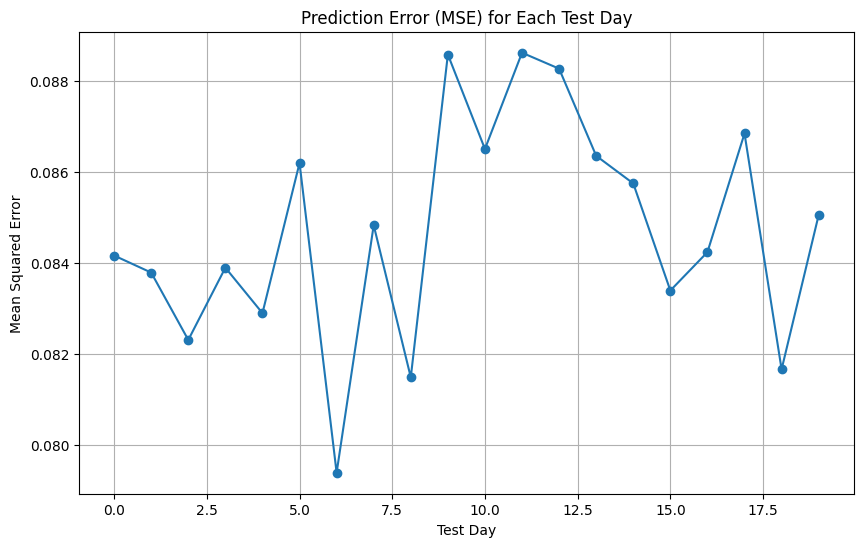

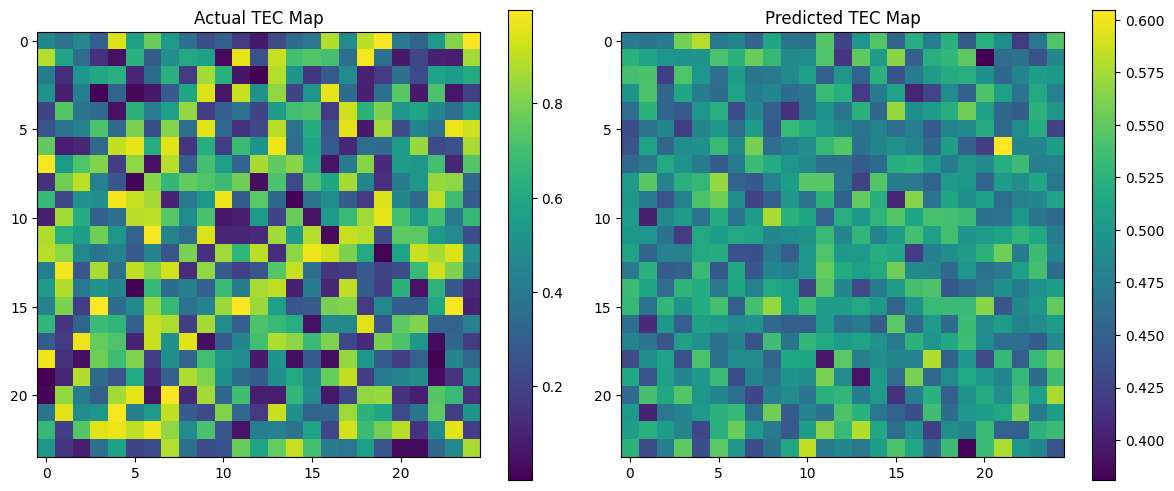

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(daily_mse)), daily_mse, marker='o')
plt.title('Prediction Error (MSE) for Each Test Day')
plt.xlabel('Test Day')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.savefig('tec_prediction_results.png')
plt.show()

day_idx = 0
pred_map = predictions[day_idx].reshape(24, 25)
actual_map = y_test[day_idx].reshape(24, 25)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(actual_map, cmap='viridis')
plt.title('Actual TEC Map')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pred_map, cmap='viridis')
plt.title('Predicted TEC Map')
plt.colorbar()

plt.tight_layout()
plt.savefig('tec_map_comparison.png')
plt.show()